# OBIA Solar Panel Segmentation using `nickyspatial`

## 1. Segment on nickyspatial

In [4]:
import os
import numpy as np
from nickyspatial import (
    LayerManager,
    read_raster,
    SlicSegmentation,
    plot_layer 
)

def run_slic_segmentation(raster_path, output_dir, scale=40.0, compactness=0.5):
    """
    Runs OBIA segmentation using SLIC on a given raster and saves the output image.

    Parameters:
        raster_path (str): Path to the input raster image.
        output_dir (str): Directory where the output image will be saved.
        scale (float): Scale parameter for SLIC segmentation.
        compactness (float): Compactness parameter for SLIC segmentation.
    """
    # Step 1: Read raster
    print(f"Reading raster from: {raster_path}")
    image_array, transform, crs = read_raster(raster_path)
    print(f"Original image shape: {image_array.shape} (bands, height, width)")
    print(f"CRS: {crs}")

    # Step 2: OBIA segmentation
    print("Running OBIA segmentation using SlicSegmentation...")
    manager = LayerManager()
    segmenter = SlicSegmentation(scale=scale, compactness=compactness)

    segmentation_layer = segmenter.execute(
        image_array,
        transform,
        crs,
        layer_manager=manager,
        layer_name="Solar_OBIA_Segments"
    )

    print("Segmentation complete.")
    print(segmentation_layer)

    # Step 3: Prepare RGB image for visualization
    image_array_rgb = np.moveaxis(image_array, 0, -1)  # (bands, H, W) → (H, W, bands)
    if image_array_rgb.max() > 1:
        image_array_rgb = image_array_rgb / 255.0

    # Step 4: Validate dimensions
    seg = segmentation_layer.raster
    print(f"Segmentation shape: {seg.shape}, Image shape: {image_array_rgb.shape[:2]}")

    if seg.shape != image_array_rgb.shape[:2]:
        raise ValueError("Mismatch between segmentation and image dimensions.")

    # Step 5: Plot using NickySpatial’s plot_layer
    print("Plotting segmentation overlay using plot_layer from NickySpatial...")

    # plot only 3 bands of the multispectral image. RGB image does not need this.
    seg_h, seg_w = segmentation_layer.raster.shape
    image_array_rgb = image_array[:3, :seg_h, :seg_w]  # shape: (3, H, W)
    
    print(f"Final RGB shape: {image_array_rgb.shape}, Segmentation shape: {segmentation_layer.raster.shape}")




    fig = plot_layer(
        layer=segmentation_layer,
        image_data=image_array_rgb,
        show_boundaries=True,
        title="SLIC Segmentation Overlaid on Ortho",
        figsize=(10, 10)
    )



    # Step 6: Save the figure
    output_path = os.path.join(output_dir, "slic_segments.png")
    fig.savefig(output_path, dpi=150)
    print(f"Segmentation overlay saved at: {output_path}")

    return segmentation_layer


Reading raster from: ortho/QuickBird.tif
Original image shape: (4, 877, 1164) (bands, height, width)
CRS: PROJCS["WGS 84 / UTM zone 54N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",141],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Running OBIA segmentation using SlicSegmentation...
Number of segments: 4537
Segmentation complete.
Layer 'Solar_OBIA_Segments' (type: segmentation, parent: None, objects: 4502)
Segmentation shape: (877, 1164), Image shape: (877, 1164)
Plotting segmentation overlay using plot_layer from NickySpatial...
Final RGB shape: (3, 877, 1164), Segmentation shape: (877, 1164)
Segmentation overlay saved at: res

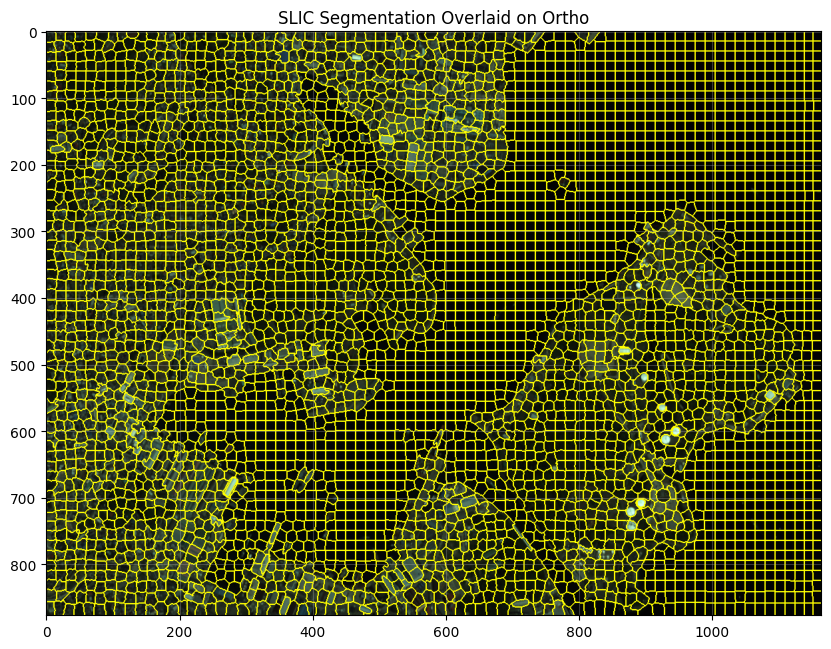

In [5]:
segmentation_layer = run_slic_segmentation(
    raster_path="ortho/QuickBird.tif",
    output_dir="results",
    scale=15.0,
    compactness=0.3
)

## 2. Register indices to objects

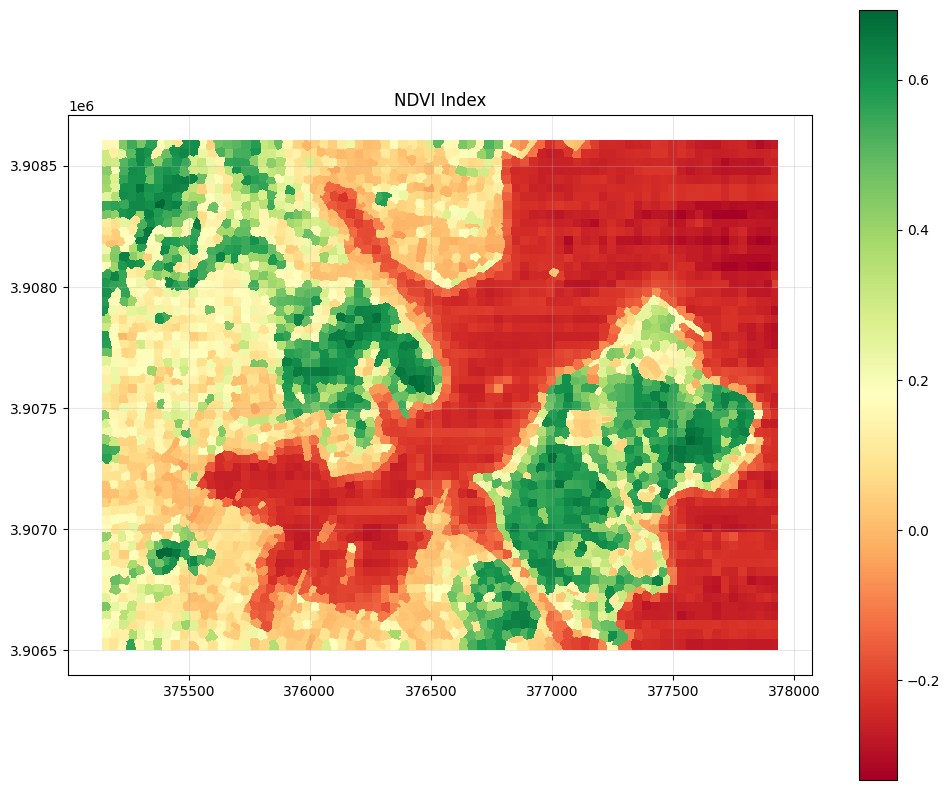

In [30]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

from nickyspatial import (
    Layer,
    LayerManager,
    RuleSet,
    read_raster,
    attach_shape_metrics,
    attach_spectral_indices,
    attach_ndvi,  
    plot_layer,
    plot_classification,
    layer_to_vector,
    layer_to_raster,
)

# --- Step 1: Setup paths ---
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

raster_path = "ortho/small_area_downsampled.tif"
geojson_path = "results/segment.geojson"

# --- Step 2: Load raster ---
image_array, transform, crs = read_raster(raster_path)

# --- Step 4: Add to manager ---
manager = LayerManager()
manager.add_layer(segmentation_layer)

# --- Step 5: Attach metrics ---
# segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")
# print(segmentation_layer.objects)
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")
# print(segmentation_layer.objects["area_pixels"].describe())


# Attach spectral means (needed for NDVI and other indices)
segmentation_layer.attach_function(
    attach_spectral_indices,
    name="spectral_indices",
    bands={
        "blue": "band_1_mean",   # Band 1 = Blue
        "green": "band_2_mean",  # Band 2 = Green
        "red": "band_3_mean",    # Band 3 = Red
    }
)

# Reuse `attach_ndvi` to compute NDVI = (NIR - R) / (NIR + R)
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",  # NIR
    red_column="band_3_mean",  # Red
    output_column="NDVI"
)

# --- Optional: Visualize NDVI ---
fig = plot_layer(segmentation_layer, attribute="NDVI", title="NDVI Index", cmap="RdYlGn")
plt.show()
# fig.savefig(os.path.join(output_dir, "1_ndvi.png"))

## 3. Rule Based Classification

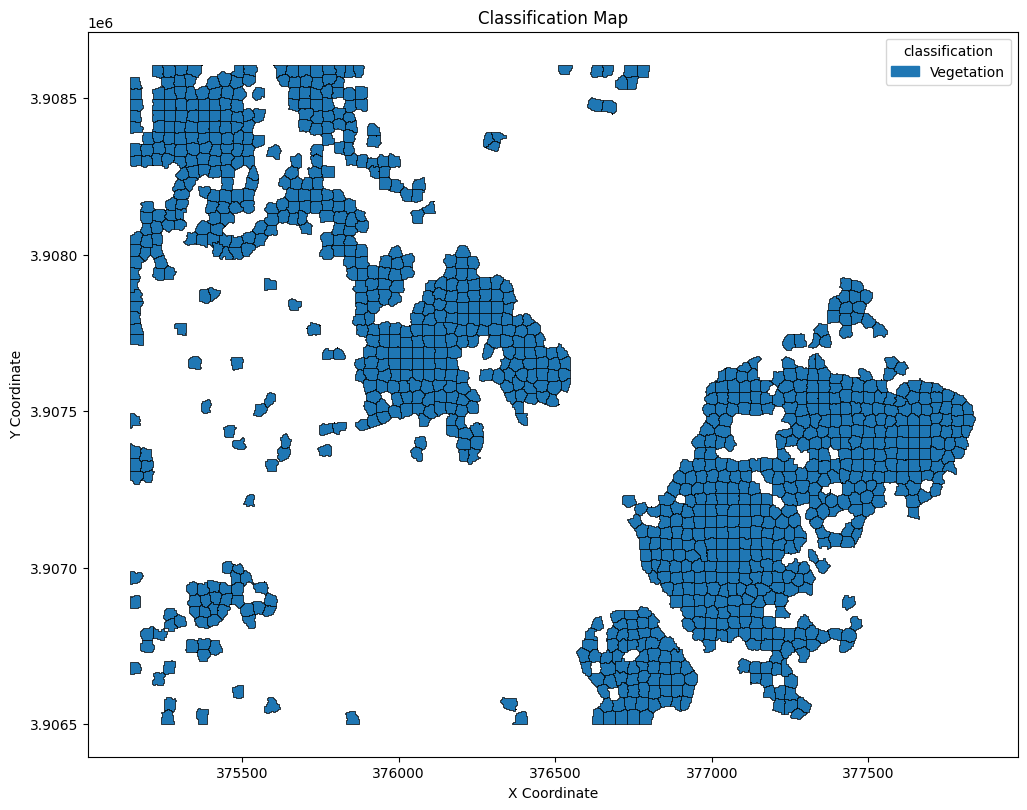

 Classification complete. Results saved to 'results/' folder.


In [17]:

rules = RuleSet(name="Test_Classification")
rules.add_rule(
    name="Vegetation", 
    condition="(NDVI > 0.3) & (NDVI < 0.9)",
)
rules.add_rule(
    name="Other", 
    condition="(NDVI < 0.3) & (NDVI > 0.9)",
)

classified_layer = rules.execute(
    segmentation_layer,
    layer_manager=manager,
    layer_name="Classified_Layer",
    result_field="classification"
)

# --- Step 7: Visualize and save ---
fig = plot_classification(classified_layer, class_field="classification")
plt.show()
# fig.savefig(os.path.join(output_dir, "2_classified.png"))

# layer_to_vector(classified_layer, os.path.join(output_dir, "classified.geojson"))
# layer_to_raster(classified_layer, os.path.join(output_dir, "classified.tif"), column="classification")

print(" Classification complete. Results saved to 'results/' folder.")


## 4. Export Segments and Classification to Geojson

In [31]:
from copy import deepcopy

# Export segmentation layer to GeoJSON
def export_layer(layer, path):
    # Step 1: Make a deep copy of the segmentation layer
    export_layer = deepcopy(layer)
    
    # Step 2: Reproject the copied layer's GeoDataFrame
    export_layer.objects = export_layer.objects.to_crs(epsg=4326)
    
    # Step 3: Set the copied layer's CRS metadata
    export_layer.crs = "EPSG:4326"
    
    # Step 4: Export to GeoJSON for leaflet map
    
    layer_to_vector(export_layer, output_path = path)
    print(f"Reprojected GeoJSON saved to: {path}")



In [32]:
segmentation_path = "results/segment.geojson"
classified_path = "results/classified.geojson"
export_layer(segmentation_layer, segmentation_path)
export_layer(classified_layer, classified_path)

Reprojected GeoJSON saved to: results/segment.geojson
Reprojected GeoJSON saved to: results/classified.geojson


## 5. Visualize in map

In [ ]:
# Download the whole folder: https://github.com/kshitijrajsharma/nickyspatial/tree/master/class_samples 
# Now, to open the leaflet map, follow the steps below. open terminal and goto the folder. You need to be on the same folder where this downloaded index.html is. Otherwise use --directory folder_name and update file paths in main.js

In [25]:
!start cmd /k python -m http.server 8001

In [26]:
import webbrowser
webbrowser.open("http://localhost:8001/index.html")

True

In [ ]:
# If you have index.html and results folder on the same folder and inside results folder: segment.geojson file, it will automatically pull the segment.geojson. Otherwise follow these steps to upload geojson.
# you can upload geojson file or relative path of your segmentation geojson file. 
# You can also upload small image file
# go to next tab to start adding the samples. 
# 1. First choose number of classes
# 2. Give class names in input fields for each class
# 3. select class in radio button and start selecting samples in the map. you will see the segment_id of the selected sample will be added on the list on the right. 
# 4. Continue this for other classes. dont forget to select radio before the classname before selecting samples in map
# 5. After samples are collected, click Download Class Values button to download json file with the list of samples with classnames. you can directly use this file to load or copy paste values from this file to use it for classification. 

In [ ]:
# In case your image is big and browser hangs, you have to create tiles using gdal2tiles. create those tiles first.

# then, go to folder inside tiles
# cd tiles
# python -m http.server 8000
# or
!start cmd /k python -m http.server 8000 --directory ortho/small_area_tiles

# Then you can paste your tile url: http://localhost:8000/{z}/{x}/{-y}.png in the map. It will open the tiles in the map.

In [ ]:
# After you have the list of samples. Run the classification

## 6. ML based classification

### 6.1. RandomForest

In [27]:
import os
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification
import matplotlib.pyplot as plt

def classify_segments_from_file(
    segment_geojson_path,
    samples_json_path=None,
    samples_dict=None,
    classifier_type="Random Forest",
    classifier_params=None,
    output_layer_name="Solar_Only_Classification",
    class_field="classification",
    show_plot=True
):
    """
    Performs supervised classification on a GeoJSON segment layer using sample IDs.

    Parameters:
        segment_geojson_path (str): Path to the GeoJSON file containing segment objects.
        samples_json_path (str): Path to a JSON file with sample IDs (optional if samples_dict is given).
        samples_dict (dict): Dictionary of labeled sample IDs (e.g. { "Solar": [...], "Non-Solar": [...] }).
        classifier_type (str): Type of classifier to use (default is "Random Forest").
        classifier_params (dict): Parameters for the classifier (default is RF with 100 trees).
        output_layer_name (str): Name of the result layer.
        class_field (str): Name of the classification field in the output.
        show_plot (bool): Whether to show the classification plot.
    
    Returns:
        result_layer: Classified Layer object
        accuracy (float): Classification accuracy
        feature_importances (DataFrame or None)
    """
    # Load segment GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Load sample IDs
    if samples_dict is None:
        if samples_json_path is None:
            raise ValueError("Either samples_dict or samples_json_path must be provided.")
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples_dict = json.load(f)

    # Setup Layer and Manager
    layer = Layer(name="SegmentLayer", type="segmentation")
    layer.objects = gdf
    manager = LayerManager()
    manager.add_layer(layer)

    # Classifier parameters
    if classifier_params is None:
        classifier_params = {"n_estimators": 100, "oob_score": True, "random_state": 42}

    classifier = SupervisedClassifier(
        name="SolarClassifier",
        classifier_type=classifier_type,
        classifier_params=classifier_params
    )

    # Perform classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples_dict,
        layer_manager=manager,
        layer_name=output_layer_name
    )

    # Plot result
    if show_plot:
        fig = plot_classification(result_layer, class_field=class_field)
        plt.show()

    print("Classification Accuracy:", accuracy)
    if feature_importances is not None:
        print("Top Features:\n", feature_importances.head())

    return result_layer, accuracy, feature_importances


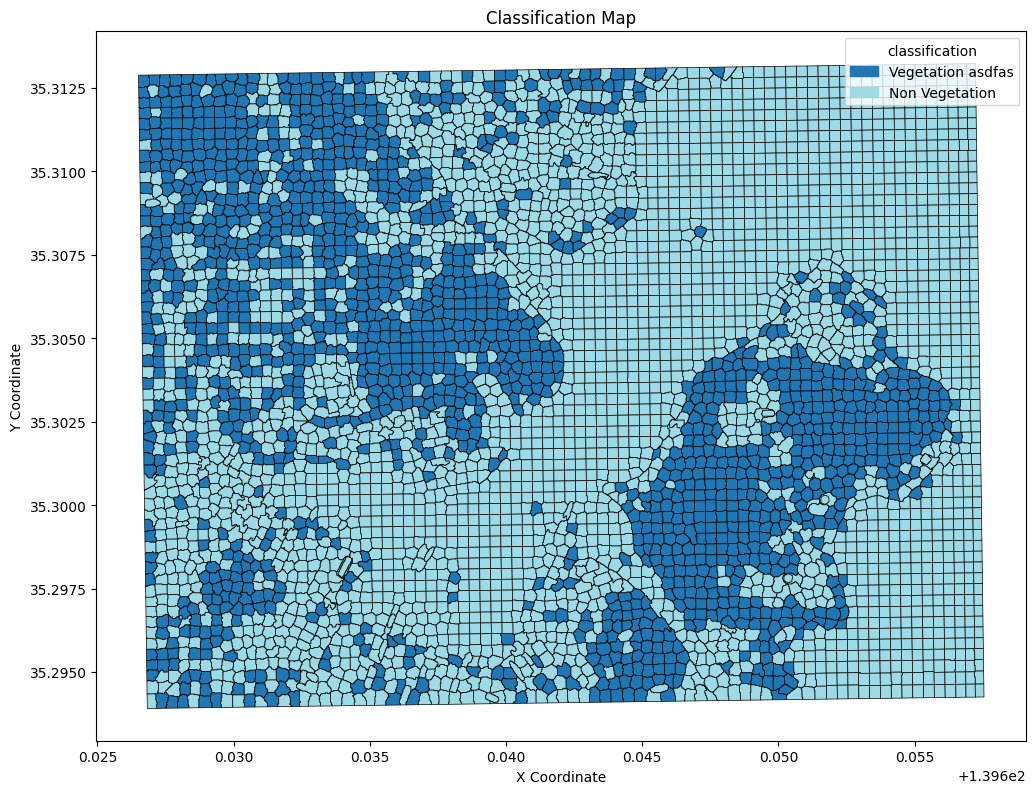

Classification Accuracy: 0.9166666666666666
Top Features:
 NDVI             12.408204
band_3_median     8.707838
band_2_mean       8.593631
band_1_mean       6.948630
band_2_median     6.226660
dtype: float64


(<nickyspatial.core.layer.Layer at 0x2abc49c42e0>,
 0.9166666666666666,
 NDVI             12.408204
 band_3_median     8.707838
 band_2_mean       8.593631
 band_1_mean       6.948630
 band_2_median     6.226660
 band_1_max        5.232964
 band_3_mean       4.929807
 band_3_min        4.720846
 band_2_min        4.587305
 band_3_std        3.525348
 VARI              3.521991
 band_4_max        3.456541
 band_4_median     3.308006
 band_3_max        3.109036
 band_2_max        2.998062
 band_1_median     2.910719
 band_1_min        2.602192
 band_4_mean       2.425472
 band_4_min        2.309261
 band_2_std        1.675049
 band_4_std        1.580012
 area_pixels       1.147834
 band_1_std        1.005677
 perimeter         0.987712
 shape_index       0.561239
 area_units        0.519964
 compactness       0.000000
 dtype: float64)

In [52]:
classify_segments_from_file(
    segment_geojson_path="results/segment.geojson",
    samples_json_path="results/samples.json", #you can either pass directly downloaded json or copy-paste the dictionary values inside file below.
    # samples_dict={
    #     "Solar": [1855, 2177, 2448],
    #     "Non-Solar": [7769, 5981, 5899]
    # }
)


In [19]:
classified_RF_path = "results/classified_RF.geojson"
export_layer(result_layer, classified_RF_path)

Reprojected GeoJSON saved to: results/classified_ML_wgs84.geojson


### 6.2. SVM

In [44]:
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification

def run_svm_classification(
    segment_geojson_path,
    samples_json_path=None,
    samples_dict=None,
    classifier_name="SVM_Classifier",
    classifier_params=None,
    source_layer_name="SegmentLayer",
    result_layer_name="SVM_Classification"
):
    """
    Perform SVM classification on a segmentation layer using NickySpatial.

    Parameters:
        segment_geojson_path (str): Path to segment GeoJSON file.
        samples_json_path (str): Optional path to JSON file with training sample IDs.
        samples_dict (dict): Optional inline dictionary of sample IDs.
        classifier_name (str): Name to give to the classifier.
        classifier_params (dict): SVM parameters.
        source_layer_name (str): Name of the segmentation layer.
        result_layer_name (str): Name of the resulting classification layer.

    Returns:
        result_layer (Layer), accuracy (float), feature_importances (None for SVM)
    """
    assert samples_json_path or samples_dict, "Provide either 'samples_json_path' or 'samples_dict'"

    # Load training samples
    if samples_json_path:
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples = json.load(f)
    else:
        samples = samples_dict

    # Load segment GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Prepare NickySpatial layer
    layer = Layer(name=source_layer_name, type="segmentation")
    layer.objects = gdf

    # Create and register LayerManager
    manager = LayerManager()
    manager.add_layer(layer)

    # Default SVM parameters if not provided
    if classifier_params is None:
        classifier_params = {
            "kernel": "rbf",
            "C": 1.0,
            "gamma": "scale",
            "probability": False
        }

    # Initialize classifier
    classifier = SupervisedClassifier(
        name=classifier_name,
        classifier_type="SVC",
        classifier_params=classifier_params
    )

    # Run classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples,
        layer_manager=manager,
        layer_name=result_layer_name
    )

    # Plot classification result
    fig = plot_classification(result_layer, class_field="classification")
    fig.show()

    print("Classification Accuracy:", accuracy)
    if result_layer and hasattr(result_layer, "objects"):
        print("Class Distribution:\n", result_layer.objects["classification"].value_counts())

    return result_layer, accuracy, feature_importances


Classification Accuracy: 0.5416666666666666
Class Distribution:
 classification
Non Vegetation    4502
Name: count, dtype: int64


C:\Users\ROG\AppData\Local\Temp\ipykernel_24876\830512344.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<nickyspatial.core.layer.Layer at 0x2abc1765630>, 0.5416666666666666, None)

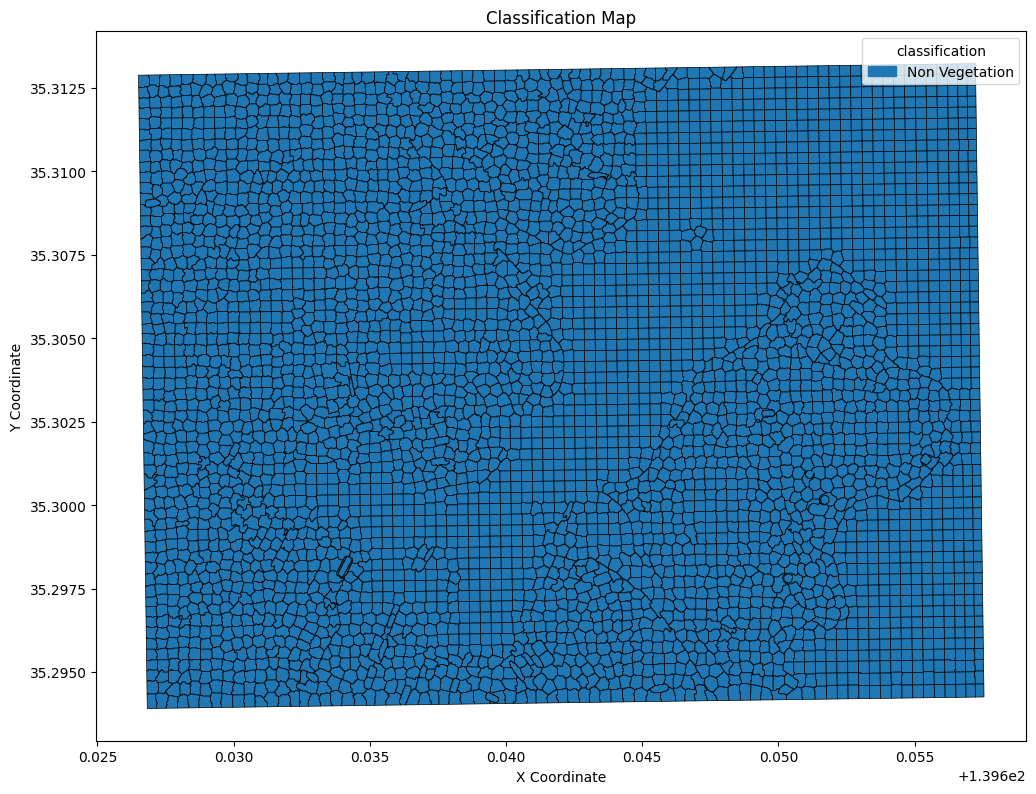

In [51]:
# Direct call
run_svm_classification(
    segment_geojson_path="results/segment.geojson",
    samples_json_path="results/samples.json", #you can either pass directly downloaded json or copy-paste the dictionary values inside file below.
    # samples_dict={
    #     "Solar": [1855, 2177, 2448],
    #     "Non-Solar": [7769, 5981, 5899]
    # },
)


### 6.3. KNN

In [49]:
import json
import geopandas as gpd
from nickyspatial.core.layer import Layer, LayerManager
from nickyspatial.core.classifier import SupervisedClassifier
from nickyspatial import plot_classification

def run_knn_classification(
    segment_geojson_path: str,
    samples_json_path: str = None,
    samples_dict: dict = None,
    n_neighbors: int = 5
):
    """
    Perform supervised classification using KNN on segmented data.

    Parameters:
    - segment_geojson_path: str → path to the segmentation GeoJSON
    - samples_json_path: str → path to JSON file with training sample IDs
    - samples_dict: dict → dictionary of manually verified sample segment IDs
    - n_neighbors: int → number of neighbors to use in KNN

    Returns:
    - result_layer: classified layer
    - accuracy: float classification accuracy
    """
    assert samples_json_path or samples_dict, "Provide either samples_json_path or samples_dict"

    # Load GeoJSON
    gdf = gpd.read_file(segment_geojson_path)

    # Load training samples
    if samples_dict is None:
        with open(samples_json_path, "r", encoding="utf-8") as f:
            samples = json.load(f)
    else:
        samples = samples_dict

    # Create segmentation layer
    layer = Layer(name="SegmentLayer", type="segmentation")
    layer.objects = gdf

    # Layer manager
    manager = LayerManager()
    manager.add_layer(layer)

    # KNN classifier
    knn_params = {"n_neighbors": n_neighbors}
    classifier = SupervisedClassifier(
        name="KNN_SolarClassifier",
        classifier_type="KNN",
        classifier_params=knn_params
    )

    # Execute classification
    result_layer, accuracy, feature_importances = classifier.execute(
        source_layer=layer,
        samples=samples,
        layer_manager=manager,
        layer_name="KNN_Classification"
    )

    # Plot results
    fig = plot_classification(result_layer, class_field="classification")
    fig.show()

    # Output
    print("Classification Accuracy:", accuracy)
    print("Feature importances not available for KNN.")

    return result_layer, accuracy


Classification Accuracy: 0.8936170212765957
Feature importances not available for KNN.


C:\Users\ROG\AppData\Local\Temp\ipykernel_24876\1279947680.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<nickyspatial.core.layer.Layer at 0x2abc1aece50>, 0.8936170212765957)

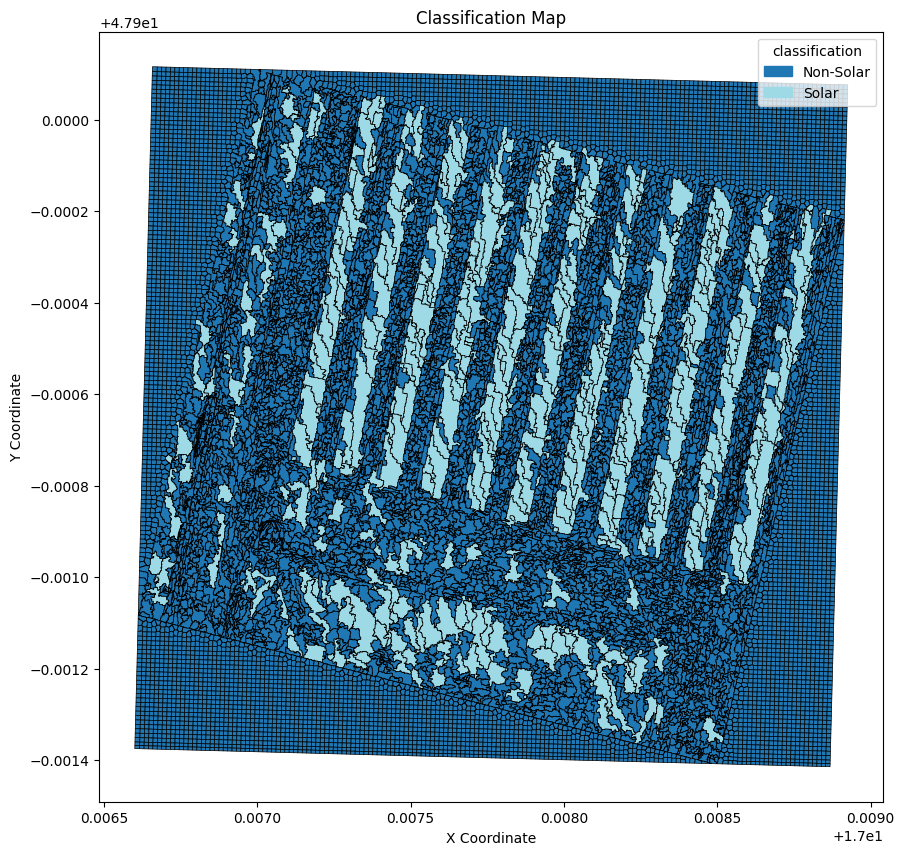

In [55]:
# Run
run_knn_classification(
    segment_geojson_path="results/segment_wgs84_final.geojson",
    samples_json_path="results/samples.json",
    # samples_dict={
    #     "Solar": [1855, 2177, 2448],
    #     "Non-Solar": [7769, 5981, 5899]
    # },
    n_neighbors=3
)


## 7. Downsample Raster
If the raster is very big it might fail because of memory error. Downsample if memory error is faced.

In [3]:
import rasterio
from rasterio.enums import Resampling

def downsample_raster(input_path, output_path, factor):
    """
    Downsample a raster by a given factor and save to a new file.
    
    Parameters:
        input_path (str): Path to the input orthophoto.
        output_path (str): Path where the downsampled raster will be saved.
        factor (int or float): Downsampling factor. E.g., 4 means image becomes 1/4 the size.
    """
    with rasterio.open(input_path) as src:
        # Calculate new dimensions
        new_width = int(src.width / factor)
        new_height = int(src.height / factor)

        # Read data with new shape
        data = src.read(
            out_shape=(
                src.count,
                new_height,
                new_width
            ),
            resampling=Resampling.bilinear
        )

        # Scale the transform accordingly
        transform = src.transform * src.transform.scale(
            src.width / new_width,
            src.height / new_height
        )

        # Write to output
        profile = src.profile
        profile.update({
            'height': new_height,
            'width': new_width,
            'transform': transform
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)
            print("saved file")

# Example usage:
downsample_raster(
    input_path="ortho/small_area.tif",
    output_path="ortho/small_area_downsampled.tif",
    factor=4  # Change as needed
)


saved file
